In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('intro_ML/data/melb_data.csv')

In [3]:
y = df.Price
X = df.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)

In [4]:
# Drop columns with missing values (simplest approach)
cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()] 
X_train_full.drop(cols_with_missing, axis=1, inplace=True)
X_valid_full.drop(cols_with_missing, axis=1, inplace=True)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [5]:
X_train.head(2)

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Landsize,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,0.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,193.0,-37.85800,144.9005,6380.0


In [6]:
# get list of categorical index
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print('Categorical variables')
print(object_cols)

Categorical variables
['Type', 'Method', 'Regionname']


### Define Function to Measure Quality of Each Approach

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [8]:
def score_melb(X_train, X_valid,y_train,y_valid):
    model = RandomForestRegressor(n_estimators=100,random_state=0)
    model.fit(X_train,y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid,preds)

In [9]:
#Score from approach 1(Drop categorical variable)
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print("MAE from Approach 1 (Drop categorical variables):")
print(score_melb(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
175703.48185157913


In [10]:
#Score from approach 2 (Ordinal Encoding)
from sklearn.preprocessing import OrdinalEncoder

#make copy to avoid change original data
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

#Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_X_train[object_cols] = ordinal_encoder.fit_transform(label_X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.transform(label_X_valid[object_cols])

print('MAE from approach 2 (Ordinal Encoding)')
print(score_melb(label_X_train, label_X_valid,y_train,y_valid))

MAE from approach 2 (Ordinal Encoding)
165936.40548390493


In [11]:
# #score from approach 3 (one-hot encoder)
from sklearn.preprocessing import OneHotEncoder

# # Apply one-hot encoder to each column with categorical data
# OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
# OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# # One-hot encoding removed index; put it back
# OH_cols_train.index = X_train.index
# OH_cols_valid.index = X_valid.index

# # Remove categorical columns (will replace with one-hot encoding)
# num_X_train = X_train.drop(object_cols, axis=1)
# num_X_valid = X_valid.drop(object_cols, axis=1)

# # Add one-hot encoded columns to numerical features
# OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
# OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

# print("MAE from Approach 3 (One-Hot Encoding):") 
# print(score_melb(OH_X_train, OH_X_valid, y_train, y_valid))

In [12]:
#import data from dir
home_train = pd.read_csv('intro_ML/data/train.csv', index_col='Id')
home_test = pd.read_csv('intro_ML/data/test.csv',index_col='Id')

In [13]:
X = home_train.copy()
X_test = home_test.copy()

In [14]:
# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

# To keep things simple, we'll drop columns with missing values
cols_with_missing = [col for col in X.columns if X[col].isnull().any()] 
X.drop(cols_with_missing, axis=1, inplace=True)
X_test.drop(cols_with_missing, axis=1, inplace=True)
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,train_size=0.8, test_size=0.2,random_state=0)

In [15]:
X_train.head(2)

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
619,20,RL,11694,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,...,108,0,0,260,0,0,7,2007,New,Partial
871,20,RL,6600,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,0,0,0,0,8,2009,WD,Normal


In [16]:
from sklearn.ensemble import RandomForestRegressor

#function for comparing approach
def score_home (X_train,X_valid,y_train,y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train,y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid,preds)

In [17]:
# Fill in the lines below: drop columns in training and validation data
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print('MAE scores for approach 1')
print(score_home(drop_X_train, drop_X_valid,y_train, y_valid))

MAE scores for approach 1
17837.82570776256


In [18]:
# Categorical columns in the training data
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely ordinal encoded
good_label_cols = [col for col in object_cols if 
                   set(X_valid[col]).issubset(set(X_train[col]))]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be ordinal encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be ordinal encoded: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'PavedDrive', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Condition2', 'Functional', 'RoofMatl']


In [19]:

# Drop categorical columns that will not be encoded
label_X_train = X_train.drop(bad_label_cols, axis=1)
label_X_valid = X_valid.drop(bad_label_cols, axis=1)

# Apply ordinal encoder 
ordinal_encoder = OrdinalEncoder()
label_X_train[good_label_cols] = ordinal_encoder.fit_transform(label_X_train[good_label_cols])
label_X_valid[good_label_cols] = ordinal_encoder.transform(label_X_valid[good_label_cols])
 # Your code here

In [20]:
print("MAE from Approach 2 (Ordinal Encoding):") 
print(score_home(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2 (Ordinal Encoding):
17098.01649543379


In [21]:
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda y: y[1])

[('Street', 2),
 ('Utilities', 2),
 ('CentralAir', 2),
 ('LandSlope', 3),
 ('PavedDrive', 3),
 ('LotShape', 4),
 ('LandContour', 4),
 ('ExterQual', 4),
 ('KitchenQual', 4),
 ('MSZoning', 5),
 ('LotConfig', 5),
 ('BldgType', 5),
 ('ExterCond', 5),
 ('HeatingQC', 5),
 ('Condition2', 6),
 ('RoofStyle', 6),
 ('Foundation', 6),
 ('Heating', 6),
 ('Functional', 6),
 ('SaleCondition', 6),
 ('RoofMatl', 7),
 ('HouseStyle', 8),
 ('Condition1', 9),
 ('SaleType', 9),
 ('Exterior1st', 15),
 ('Exterior2nd', 16),
 ('Neighborhood', 25)]

In [22]:
# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 10]

# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols)

Categorical columns that will be one-hot encoded: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Exterior1st', 'Exterior2nd', 'Neighborhood']


In [23]:
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[low_cardinality_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

/home/yogasugitha/.local/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Pipelines

Pipelines are a simple way to keep your data preprocessing and modeling code organized. Specifically, a pipeline bundles preprocessing and modeling steps so you can use the whole bundle as if it were a single step.

Many data scientists hack together models without pipelines, but pipelines have some important benefits. Those include:

Cleaner Code: Accounting for data at each step of preprocessing can get messy. With a pipeline, you won't need to manually keep track of your training and validation data at each step.
Fewer Bugs: There are fewer opportunities to misapply a step or forget a preprocessing step.
Easier to Productionize: It can be surprisingly hard to transition a model from a prototype to something deployable at scale. We won't go into the many related concerns here, but pipelines can help.
More Options for Model Validation: You will see an example in the next tutorial, which covers cross-validation.

In [24]:
# Separate target from predictors
y = df.Price
X = df.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [25]:
# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cn for cn in X_train_full if X_train_full[cn].nunique() < 10
                    and X_train_full[cn].dtype == 'object']
#select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [26]:
X_train.head(2)

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,1.0,0.0,NaN,1940.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,1.0,193.0,NaN,NaN,-37.85800,144.9005,6380.0


In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [28]:
model = RandomForestRegressor(n_estimators=100, random_state=0)

In [29]:
from sklearn.metrics import mean_absolute_error

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 160679.18917034855


### Cross Validation

In [30]:
#use data from melb housing snashot
#subset as predictors
cols_to_use =  ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = df[cols_to_use]

#select target
y = df.Price

In [31]:
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                                ('model', RandomForestRegressor(n_estimators=50, random_state=0))])

In [32]:
from sklearn.model_selection import cross_val_score
#multiply by -1 since sklearn calculates *negative* MAE
score = -1 * cross_val_score(my_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')

print('MAE scores: \n', score)

MAE scores: 
 [301628.7893587  303164.4782723  287298.331666   236061.84754543
 260383.45111427]


In [33]:
print("Average MAE score (across experiments):")
print(score.mean())

Average MAE score (across experiments):
277707.3795913405


In [34]:
#use dataset from home_train and home_test
train_data = home_train.copy()
test_data = home_test.copy()

train_data.dropna(axis='rows',inplace=True,subset={'SalePrice'})
y = train_data.SalePrice
train_data.drop(['SalePrice'], axis='columns', inplace=True)

#select numeric columns only
num_cols = [ x for x in train_data.columns if train_data[x].dtypes in ['int64','float64'] ]
X = train_data[num_cols].copy()
X_test = test_data[num_cols].copy()

In [35]:
X.head(2)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007


In [36]:
#create pipelines
my_peps = Pipeline(steps=[
    ('preprocessor', SimpleImputer()),
    ('model', RandomForestRegressor(n_estimators=50, random_state=0))
])

In [37]:

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("Average MAE score:", scores.mean())

Average MAE score: 18276.410356164386


In [38]:
def get_score(n_estimators):
    my_pipeline = Pipeline(steps=[
        ('preprocessor', SimpleImputer()),
        ('model', RandomForestRegressor(n_estimators=n_estimators, random_state=0))
    ])
    scores = -1 * cross_val_score(my_pipeline, X, y,cv=3, scoring='neg_mean_absolute_error')
    return scores.mean()

In [41]:
results = {}
for i in range(1,9):
    results[50*i] = get_score(50*i)

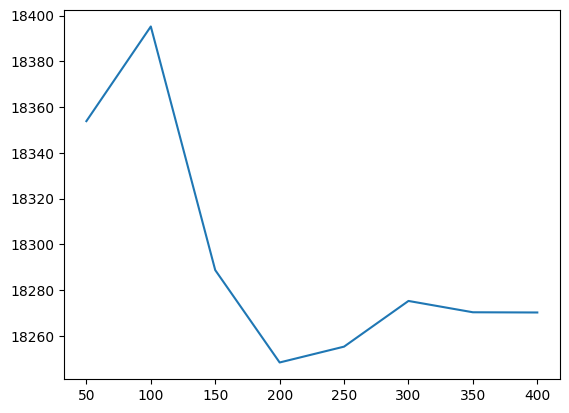

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [43]:
import tensorflow as tf

2023-01-18 19:24:33.678112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [44]:
print(tf.reduce_sum(tf.random.normal([1000, 1000])))

tf.Tensor(-617.28076, shape=(), dtype=float32)


2023-01-18 19:24:38.818530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 19:24:38.828905: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [45]:
print(tf.__file__)

/home/yogasugitha/miniconda3/lib/python3.9/site-packages/tensorflow/__init__.py


In [46]:
from tensorflow import keras

### XGBoost

#### Definition

*Gradient boosting* is a method that goes through cycles to iteratively add models into an ensemble.

It begins by initializing the ensemble with a single model, whose predictions can be pretty naive. (Even if its predictions are wildly inaccurate, subsequent additions to the ensemble will address those errors.)

Then, we start the cycle:

- First, we use the current ensemble to generate predictions for each observation in the dataset. To make a prediction, we add the predictions from all models in the ensemble.
- These predictions are used to calculate a loss function (like mean squared error, for instance).
- Then, we use the loss function to fit a new model that will be added to the ensemble. Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss. (Side note: The "gradient" in "gradient boosting" refers to the fact that we'll use gradient descent on the loss function to determine the parameters in this new model.)
- Finally, we add the new model to ensemble, and ...
- ... repeat!

#### implementation and practice

In [47]:
dfXG = df.copy()

In [48]:
dfXG.head(2)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0


In [49]:
# Select subset of predictors
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = dfXG[cols_to_use]

# select target
y = dfXG.Price

# split into data train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In [79]:
from xgboost import XGBRegressor
xg_model = XGBRegressor(n_estimators=500, learning_rate=0.05, n_jobs=4)
xg_model.fit(X_train, y_train,early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)],
             verbose=False)

/home/yogasugitha/.local/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=4, num_parallel_tree=None, predictor=None,
             random_state=None, ...)

- **early_stopping_round** => automatically find ideal value for n_estimators
require *eval_set* when using early_stopping_round
- **learning_rate** => multiply predictors from each model by a small number, works well with early_stopping_round

In [80]:
preds = xg_model.predict(X_valid)
print('mean_absolute_error: ' + str (mean_absolute_error(preds, y_valid)))

mean_absolute_error: 234650.15859720178


##### **exercise**

In [92]:
#home-data will be used for this exercise
xg_train = pd.read_csv('intro_ML/data/train.csv', index_col='Id')
xg_test = pd.read_csv('intro_ML/data/test.csv', index_col='Id')

In [94]:
#remove row with missing target, separate target from predictors
X = xg_train.copy()
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice              
X.drop(['SalePrice'], axis=1, inplace=True)

In [95]:
# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [96]:
# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]
# Select numeric column
numeric_cols = [cl for cl in X_train_full.columns if X_train_full[cl].dtype in ['int64', 'float64']]

In [97]:
#keep selected column
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = xg_test[my_cols].copy()

In [103]:
#one-hot encode tha data
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left',axis=1)

**1 : Build Model**

In [106]:
from xgboost import XGBRegressor
my_model_1 = XGBRegressor(random_state=0)
my_model_1.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [109]:
predictions_1 = my_model_1.predict(X_valid)
mae_1 = mean_absolute_error(predictions_1, y_valid)
print('Mean Absolute Error: ', mae_1)

Mean Absolute Error:  17662.736729452055


**Step 2: Improve the model**

In [112]:
my_model_2 = XGBRegressor(n_estimators=100, learning_rate=0.05)
my_model_2.fit(X_train,y_train)
predictions_2 = my_model_2.predict(X_valid)
mae_2 = mean_absolute_error(predictions_2, y_valid)
print('Mean Absolute Error:', mae_2)

Mean Absolute Error: 17213.82253317637


**Step 3: Break the model**

In [114]:
my_model_3 = XGBRegressor(n_estimators=1)
my_model_3.fit(X_train, y_train)
# Get predictions
predictions_3 = my_model_3.predict(X_valid)

# Calculate MAE
mae_3 = mean_absolute_error(predictions_3, y_valid)
print("Mean Absolute Error:" , mae_3)


Mean Absolute Error: 127895.0828807256


## Data Leakage

### Introduction

**Data leakage** (or leakage) happens when your training data contains information about the target, but similar data will not be available when the model is used for prediction. This leads to high performance on the training set (and possibly even the validation data), but the model will perform poorly in production.

In other words, leakage causes a model to look accurate until you start making decisions with the model, and then the model becomes very inaccurate.

There are two main types of leakage: 
- target leakage
occurs when your predictors include data that will not be available at the time you make predictions. It is important to think about target leakage in terms of the timing or chronological order that data becomes available, not merely whether a feature helps make good predictions.
- train-test contamination.
Recall that validation is meant to be a measure of how the model does on data that it hasn't considered before. You can corrupt this process in subtle ways if the validation data affects the preprocessing behavior. This is sometimes called train-test contamination.

For example, imagine you run preprocessing (like fitting an imputer for missing values) before calling train_test_split(). The end result? Your model may get good validation scores, giving you great confidence in it, but perform poorly when you deploy it to make decisions.

### Learn and Practice

In [117]:
ccd = pd.read_csv('data/AER_credit_card_data.csv', true_values=['yes'], false_values=['no'])
ccd.head(2)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,True,0,37.66667,4.52,0.033270,124.983300,True,False,3,54,1,12
1,True,0,33.25000,2.42,0.005217,9.854167,False,False,3,34,1,13


In [120]:
#select target
y = ccd.card
y.head(2)

0    True
1    True
Name: card, dtype: bool

In [122]:
#select predictor (in way, we must drop column of y target)
X = ccd.drop(['card'], axis='columns')
X.head(2)

,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,0,37.66667,4.52,0.033270,124.983300,True,False,3,54,1,12
1,0,33.25000,2.42,0.005217,9.854167,False,False,3,34,1,13


In [124]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

#since there is no preprocessing
my_pipe = make_pipeline(RandomForestClassifier(n_estimators=100))
cv_score = cross_val_score(my_pipe, X, y,cv=5, scoring='accuracy')
print('Cross-validations accuracy: %f' %cv_score.mean())

Cross-validations accuracy: 0.981052


In [125]:
expenditures_cardholders = X.expenditure[y]
expenditures_noncardholders = X.expenditure[~y]

print('Fraction of those who did not receive a card and had no expenditures: %.2f' \
      %((expenditures_noncardholders == 0).mean()))
print('Fraction of those who received a card and had no expenditures: %.2f' \
      %(( expenditures_cardholders == 0).mean()))


Fraction of those who did not receive a card and had no expenditures: 1.00
Fraction of those who received a card and had no expenditures: 0.02


In [126]:
# Drop leaky predictors from dataset
potential_leaks = ['expenditure', 'share', 'active', 'majorcards']
X2 = X.drop(potential_leaks, axis=1)

# Evaluate the model with leaky predictors removed
cv_scores = cross_val_score(my_pipe, X2, y, 
                            cv=5,
                            scoring='accuracy')

print("Cross-val accuracy: %f" % cv_scores.mean())

Cross-val accuracy: 0.832443


#### Exercise